# Models 

## Methodology  

In order to vectorize our data for modeling purpose we will use the Count Vectorizer which uses a bag of words approach. Each string is tokenized by words and transformed into columns retaining the number of times the word appears in the string. 

To establish a baseline to compare our models to we will use Dummy Classifier which simply guesses at random the classification of each observation. 


We will use a multinomial naive bayes and a decision tree model to optimize our metrics. 

For each model we will begin with the default hyperparameters and attempt to tune the hyperparamters to see if it is possible to obtain better results. 


In [1]:
# imports 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# transformer
from sklearn.feature_extraction.text import CountVectorizer

# model pipeline 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
# models 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

#distributions for searching different hyperparamters
from scipy.stats import uniform, loguniform,randint

# model metrics
import sklearn.metrics

In [2]:
# helper function to visualize impact of different values for hyperparamters 
def graph_cv_results(model,param):
  'returns graph of different param values tried by search against F1 score'
  model_results = pd.DataFrame(model.cv_results_)
  x=model_results[f"param_{param}"]
  y=model_results['mean_test_f1_weighted']
  sns.scatterplot(x=x,y=y)
  #ymax = max(y)
  #xpos = y.index(ymax)
  return #f"Max Value of mean_test_f1_weighted occurs at {max(x)} "

In [23]:
# evaluation metrics for modelling 
metrics= ['accuracy','f1_weighted']

# Dummy Classifier

In [4]:
# load dataset 
df =pd.read_csv('./data/raw_posts.csv')

In [5]:
# define X and y 
X= df['title'] 
y=df['subreddit']

# Define training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [6]:
# Instantiate CountVectorizer 
cvec= CountVectorizer()

# vectorize train and testing predictor sets 
Xcvec_train= cvec.fit_transform(X_train)
Xcvec_test= cvec.transform(X_test)

In [7]:
# instantiate dummy classier to randomly guess 
dummy = DummyClassifier(strategy='uniform',random_state=42)

# fit dummy model 
dummy.fit(Xcvec_train,y_train)

DummyClassifier(random_state=42, strategy='uniform')

In [10]:
# helper function 
def model_eval(model):
  'return accuracy and weighted F1 score for given model on training and test sets'
  met = {'Training Accur Score':sklearn.metrics.accuracy_score(y_train,model.predict(X_train)),
         'Test Accur Score':sklearn.metrics.accuracy_score(y_test,model.predict(X_test)),
         'Training F1':sklearn.metrics.f1_score(y_train,model.predict(X_train),average='weighted'),
         'Test F1':sklearn.metrics.f1_score(y_test,model.predict(X_test),average='weighted') }
  return met       

In [11]:
model_eval(dummy)

{'Training Accur Score': 0.4994662193076102,
 'Test Accur Score': 0.5121225983531564,
 'Training F1': 0.5007761425971449,
 'Test F1': 0.5133863949830523}

The dummy classification model gives us 50% accuracy and F1 score for both testing and training sets. 

This is not surprising considering it is guessing at random which class to label each observation. 

If our models are not able to perform better then these baseline metrics then it is not worth trying to build a model to classify posts.  

# Multinomial Naive Bayes 

A multinomial naive bayes classifier is a probabilistic model that assumes independece between the predictors. 
  - For each observation it generates a probability distribution to predict the likely class based on previous observations. 
  - When working with text data the assumption of independence is generally violated because words in a sentence are usually related and not independent of other words in the sentence. 
  - These models usually perform well on text data even though the independence assumption is almost always violated. 
  - This model requires features to have positive values. Since we are using a bag-of-words vectorizer this requirement will be satisfied. 


## Default Hyperparamters 

In [74]:
# Default hyperparamters 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()),
                     ('nb',MultinomialNB())
])
# fit pipeline with default hyperparamters  
cvec_pipe.fit(X_train,y_train)                     

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [73]:
model_eval(cvec_pipe)

{'Training Accur Score': 0.917874027756596,
 'Test Accur Score': 0.8085544373284538,
 'Training F1': 0.9179721607718556,
 'Test F1': 0.8087578658456591}

- With default hyperparamters we get high test accuracy (and F1 score) of 91 on our training set. 
- However, on the test sets the model did not perform as well scoring only about 0.80 
  - This suggests that this model is overfit. 
- To try and reduce the overfitting of our model we can tune the hyperparamters on both the transformer , CountVectorizer, and the estimator, multinomial naive bayes.   

## Hyperparamter Tuning

### CountVectorizer

In [12]:
# helper function
def cv_eval(model,param):
  '''returns dataframe with cv_results for given param sorted by mean_test_f1_weight'''  
  result= pd.DataFrame(model.cv_results_)[['mean_test_accuracy','mean_test_f1_weighted',param]].sort_values(by='mean_test_f1_weighted',ascending=False)
  return result.dropna().reset_index(drop=True)

In [31]:
# helper function 
def gs_eval(model,params):
  '''for grid search returns cv results for params sorted by F1 score'''
  mets = pd.DataFrame(model.cv_results_)[['mean_test_accuracy','mean_test_f1_weighted']]
  par_list = [f"param_{par}" for par in params]
  pars= pd.DataFrame(model.cv_results_)[par_list]
  return pd.concat([mets,pars],axis=1).sort_values(by='mean_test_f1_weighted',ascending=False)

Grid Search over lowercase, stop words, ngram_range to see which combination of these hyperparamters leads to the best results. 

In [24]:
# tuning countvectorizer parameters 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()),
                     ('nb',MultinomialNB())
])
#parameters for gridsearch 
cvec_params = {
    'cvec__lowercase': [True, False],
    'cvec__stop_words': ['english',None],
    'cvec__ngram_range':[(1,1),(1,2),(2,2),(1,3)]

    
}
# instantiate grid search
cvec_gs = GridSearchCV(cvec_pipe,cvec_params,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1)
# fit gridsearch 
cvec_gs.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__lowercase': [True, False],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
                         'cvec__stop_words': ['english', None]},
             refit=False, scoring=['accuracy', 'f1_weighted'], verbose=1)

In [33]:
# see which values lead had best metric scores 
gs_eval(cvec_gs,['cvec__lowercase','cvec__stop_words','cvec__ngram_range']).head

,mean_test_accuracy,mean_test_f1_weighted,param_cvec__lowercase,param_cvec__stop_words,param_cvec__ngram_range
15,0.875248,0.875572,False,None,"(1, 3)"
11,0.874257,0.874583,False,None,"(1, 2)"
9,0.868843,0.869176,False,None,"(1, 1)"
14,0.856947,0.857159,False,english,"(1, 3)"
10,0.855803,0.856011,False,english,"(1, 2)"


Best hyperparamters based on our gridsearch: 

cvec__lowercase: False 
  - When tokenizing if each word is not transformed to lowercase our model performs better. This suggests that there is a difference in capitalizations between r/theonion and r/nottheonion

cvec__stop_words: None
  - If common stop words are not removed from our features our model performs better. This suggests that there is a difference in the number of stop words between the subreddits. 

cvec__ngram_range: (1,3) 
  - If each title is broken into unigrams, bigrams, and trigrams our model performs better. 
  - This suggests that groups of words, length 1/2/3, perform better then just looking at each word seperately. Considering that titles of posts on both subreddits are not very long it is not surprising that 2 or 3 word combinations provide more information then each word indiviually. 
  - Since the value of (1,3) was at the top threshold tested we will test a few values higher to see if indeen (1,3) is optimal or larger values perform better.  


In [36]:
# Check higher ngram_ranges 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()),
                     ('nb',MultinomialNB())
])
#parameters for gridsearch based on previous search 
cvec_params2 = {
    'cvec__lowercase': [False], 
    'cvec__stop_words': [None], 
    'cvec__ngram_range': [(1,3),(2,3),(3,3),(4,1)]   # trying higher ranges 
}

# instantiate grid search 
cvec_gs2 = GridSearchCV(cvec_pipe,cvec_params,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1)
#fit grid search
cvec_gs2.fit(X_train,y_train)

# see results
gs_eval(cvec_gs2,['cvec__ngram_range']).head()

Fitting 3 folds for each of 16 candidates, totalling 48 fits


,mean_test_accuracy,mean_test_f1_weighted,param_cvec__ngram_range
15,0.875248,0.875572,"(1, 3)"
11,0.874257,0.874583,"(1, 2)"
9,0.868843,0.869176,"(1, 1)"
14,0.856947,0.857159,"(1, 3)"
10,0.855803,0.856011,"(1, 2)"


Based on our search we see that an ngram range of (1,3) is indeed the optimal value for this hyperparamter based on our evaluation metrics. 



Next: 

min_df gives minimum frequency of each word within text to have in order for it to be included in vocabulary. 
- The default in sklearn is to include all words that occur at least once.
-  If we are more strict and require a certain threshold to be met before adding features to the model this could improve performance by not looking at words that only show up once. 
  - This will give more weight to words that occur more frequently. 



In [51]:
# Tune cvec_min_df 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()), #lowercase=False,stop_words=None,ngram_range=(1,3)
                    ('nb',MultinomialNB())
])
#parameters for Random Search 
cvec_params3 = {
    'cvec__lowercase': [False], 
    'cvec__stop_words': [None],
    'cvec__ngram_range': [(1,3)],
    'cvec__min_df': uniform(0,1) # look at values between 0 and 1 

    
}
# instantiate randomized search trying 100 values between 0 and 1 for min_df 
cvec_gs3 = RandomizedSearchCV(cvec_pipe,cvec_params3,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1,random_state=42,
                              n_iter=100)
#fit randomized search 
cvec_gs3.fit(X_train,y_train)
# check results
gs_eval(cvec_gs3,['cvec__min_df']).head()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/tanveer/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.59974445 0.59974445
 0.81744669        nan        nan        nan 0.86533462        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.69765111        nan        nan
        nan        nan        nan        nan        nan 0.8198107
        nan 0.55109044 0.81744669        nan        nan        nan
        nan 0.78465726        nan        nan 0.71633485        nan
 0.84070446        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan 0.7858772         nan 0.82064956        nan
        nan        nan        nan        nan        nan        nan
 0.69765111        nan 0.8011283         nan        nan        nan
 0.87562903        nan        nan        nan 

,mean_test_accuracy,mean_test_f1_weighted,param_cvec__min_df
72,0.875629,0.875845,0.005522
10,0.865335,0.865245,0.020584
98,0.857404,0.857065,0.025419
42,0.840704,0.839200,0.034389
58,0.820650,0.817189,0.045227


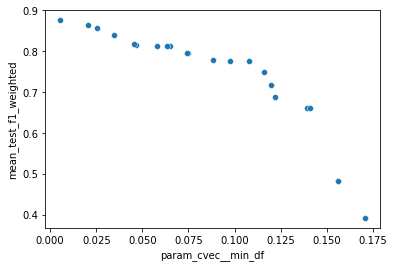

In [53]:
# graph values of min_df vs F1 score 
graph_cv_results(cvec_gs3,'cvec__min_df')

cvec__min_df
  - min_df and F1 appear to be inversely related. As min_df decreases the F1 score increases. 
    - This suggests that words with low frequency of occurence in our sample set have a large impact on the model. 
    - The highest value of F1 occurs between 0 and 0.025 
      - Since it appears to be inversely related if we look at even smaller values of min_df does that increase F1 score? 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


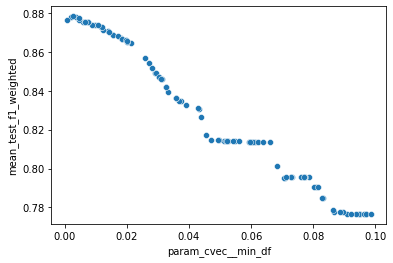

In [54]:
# Tune cvec_min_df with values closer to 0 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()), #lowercase=False,stop_words=None,ngram_range=(1,3)
                    ('nb',MultinomialNB())
])
#parameters for Random Search 
cvec_params3 = {
    'cvec__lowercase': [False], 
    'cvec__stop_words': [None], 
    'cvec__ngram_range': [(1,3)],  
    'cvec__min_df': uniform(0,0.1) # look at values between 0 and 0.1 

    
}
# instantiate randomized search trying 100 values between 0 and 0.1 for min_df 
cvec_gs3 = RandomizedSearchCV(cvec_pipe,cvec_params3,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1,random_state=42,
                              n_iter=100)
#perform search 
cvec_gs3.fit(X_train,y_train)
#check results
graph_cv_results(cvec_gs3,'cvec__min_df')

cvec_min_df 
  - For values between 0 and 0.1 the trend continues. As min_df gets closer to 0 the F1 score increases. 
  - If we look at even smaller values of min_df does F1 score keep increasing? 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


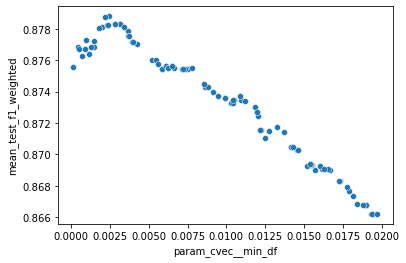

In [55]:
# Tune cvec_min_df between 0 and 0.02 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()), 
                    ('nb',MultinomialNB())
])
#parameters for Random Search 
cvec_params3 = {
    'cvec__lowercase': [False], 
    'cvec__stop_words': [None], 
    'cvec__ngram_range': [(1,3)],  
    'cvec__min_df': uniform(0,0.02) # search between 0 and 0.02

    
}
# instantiate randomized search trying 100 values between 0 and 0.02 for min_df 
cvec_gs3 = RandomizedSearchCV(cvec_pipe,cvec_params3,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1,random_state=42,
                              n_iter=100)
# perform search
cvec_gs3.fit(X_train,y_train)
#check results
graph_cv_results(cvec_gs3,'cvec__min_df')

cvec__min_df
  - F1 score increases as min_df goes from 0 until somewhere between 0.0025 and 0.005 after which it begins to decrease. 
  - To locate the optimal value lets search between 0 and 0.006 

Fitting 3 folds for each of 300 candidates, totalling 900 fits


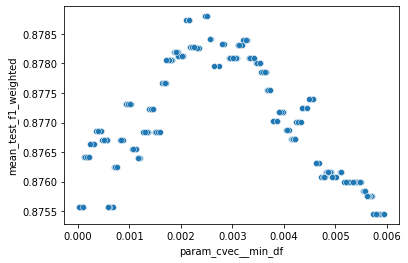

In [60]:
# Tune cvec_min_df between 0 and 0.006 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()), 
                    ('nb',MultinomialNB())
])
#parameters for Random Search 
cvec_params3 = {
    'cvec__lowercase': [False], 
    'cvec__stop_words': [None], 
    'cvec__ngram_range': [(1,3)],   
    'cvec__min_df': uniform(0,0.006) # between 0 and 0.006 

    
}
# instantiate random search of 100 values between 0 and 0.006 
cvec_gs3 = RandomizedSearchCV(cvec_pipe,cvec_params3,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1,random_state=42,
                              n_iter=300)
# perform search 
cvec_gs3.fit(X_train,y_train)
#check results 
graph_cv_results(cvec_gs3,'cvec__min_df')

In [61]:
gs_eval(cvec_gs3,['cvec__min_df']).head(10)

,mean_test_accuracy,mean_test_f1_weighted,param_cvec__min_df
106,0.878527,0.878796,0.002462
130,0.878527,0.878796,0.002504
195,0.878451,0.878726,0.002095
63,0.878451,0.878726,0.002141
268,0.878451,0.878726,0.002157
78,0.878451,0.878726,0.002151
293,0.878451,0.878726,0.002161
18,0.878146,0.878412,0.002592
125,0.878146,0.878412,0.002563
97,0.878146,0.878412,0.002565


The mean f1 weighted score peaks in between 0.002 and 0.003 

For our purposes we will use 0.0025 as a balanced middle point since a cluster of values around that seems to converge. 

A couple of points below 0.0025 have higher F1 score but not enough cluster of points to give us confidence in using that for our modeling purposes. 

Next we can try to tune the max_df hyperparamter in CountVectorizer transformer. 
  - Similar to min_df but this provide a maximum cutoff point to ignore words with frequency greater then the value of this hyperparamter
  - The default in sklearn is not to have maximum cuttoff. 
  - If a word appears very commonly in both subreddits then it would not help much in classifying and only increase complexity of the model. 


Fitting 3 folds for each of 100 candidates, totalling 300 fits


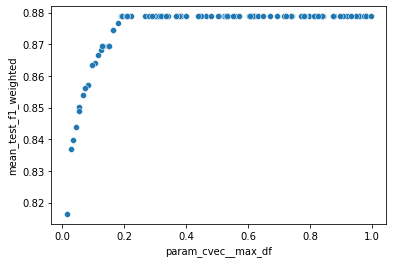

In [65]:
# Tune cvec_max_df 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()), #lowercase=False,stop_words=None,ngram_range=(1,3)
                    ('nb',MultinomialNB())
])
#parameters for Random Search 
cvec_params4 = {
    'cvec__lowercase': [False], 
    'cvec__stop_words': [None], 
    'cvec__ngram_range': [(1,3)],   
    'cvec__min_df': [ 0.0025], 
    'cvec__max_df': uniform(0.01,1) # try values between 0.01 and 1 

    
}
# instantiate random search trying 100 values between 0.01 and 1 
cvec_gs4 = RandomizedSearchCV(cvec_pipe,cvec_params4,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1,random_state=42,
                              n_iter=100)
# perform search 
cvec_gs4.fit(X_train,y_train)
# check results
graph_cv_results(cvec_gs4,'cvec__max_df')

From the graph we see that the F1 score peaks around 0.2 and stays consistent for all values greater then that. 

For our purposes we could use any value from 0.2 to 1 and have similar results in terms of our metrics so we will arbitrarily go with 0.3 for the purpose of our analysis. 

Next we will tune the alpha parameter for Multinomial Naive Bayes estimator. 
  - This is a smoothing paramter with 0 being no smoothing and increasing values indicating more smoothing performed. 
  - The default value in sklearn is 1 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


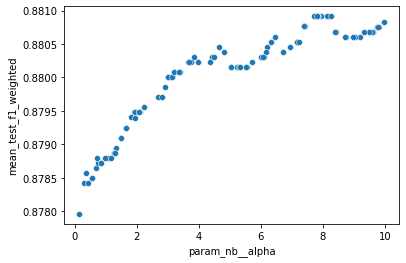

In [67]:
# Tune nb__alpha from 0.1 to 10 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()), #lowercase=False,stop_words=None,ngram_range=(1,3)
                    ('nb',MultinomialNB())
])
#parameters for Random Search 
cvec_params5 = {
    'cvec__lowercase': [False], 
    'cvec__stop_words': [None],
    'cvec__ngram_range': [(1,3)],  
    'cvec__min_df': [ 0.0025], 
    'cvec__max_df': [0.3],
    'nb__alpha': uniform(0.1,10) # try values between 0.1 and 10 

    
}
# instantiate random search trying 100 values between 0.1 and 10 
cvec_gs5 = RandomizedSearchCV(cvec_pipe,cvec_params5,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1,random_state=42,
                              n_iter=100)
# perform search
cvec_gs5.fit(X_train,y_train)
# check results 
graph_cv_results(cvec_gs5,'nb__alpha')

nb__alpha
  - As alpha increases so does the F1 score but not drastically 
  - To see how far this trend continues we can search over larger values of alpha to find the maximum F1 score 

Fitting 3 folds for each of 200 candidates, totalling 600 fits


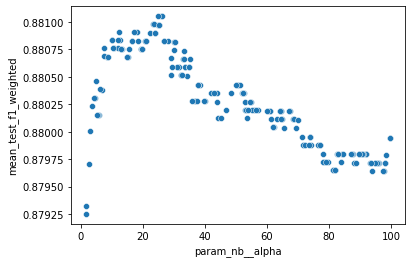

In [75]:
# Tune nb__alpha going from 1 to 100 

#instantiate pipeline 
cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer()), #lowercase=False,stop_words=None,ngram_range=(1,3)
                    ('nb',MultinomialNB())
])
#parameters for Random Search 
cvec_params5 = {
    'cvec__lowercase': [False], #[True, False],
    'cvec__stop_words': [None], # ['english',None],
    'cvec__ngram_range': [(1,3)],   # [(1,3),(2,3),(3,3),(4,1)]       # [(1,1),(1,2),(2,2),(1,3)]
    'cvec__min_df': [ 0.0025], #uniform(0,0.006)
    'cvec__max_df': [0.3], # uniform(0.01,1)
    'nb__alpha': uniform(1,100)

    
}

cvec_gs5 = RandomizedSearchCV(cvec_pipe,cvec_params5,cv=3,n_jobs=-1,scoring=metrics,refit=False,verbose=1,random_state=42,
                              n_iter=200)
cvec_gs5.fit(X_train,y_train)

graph_cv_results(cvec_gs5,'nb__alpha')
#gs_eval(cvec_gs3,['cvec__min_df']).head()

The F1 score peaks at alpha values of around 20 

#### Final Multinomial Naive Bayes 

Based on the hyperparamters from our tuning process we can build a final multinomial naive bayes model to see how it compares with our baseline model in terms of our evaluation metrics. 

In [126]:
# Final Naive Bayes Model based on optimal hyperparmaters 


# instantiate transformer 
vect =CountVectorizer(lowercase=False,stop_words= [None],ngram_range=(1,3),
                                             max_df=0.3,min_df= 0.0025)
# transform training and test sets 
X_nb_train= vect.fit_transform(X_train)
X_nb_test= vect.transform(X_test)
#instantiate estimator 
nb_final= MultinomialNB(alpha=20)
# fit estimator 
nb_final.fit(X_nb_train,y_train)
# check metrics
result_metrics(nb_final_pipe)

{'Training Accur Score': 0.8816531950587159,
 'Test Accur Score': 0.8888380603842635,
 'Training F1': 0.8818947569457736,
 'Test F1': 0.8890644220922252}

- Compared to the baseline model with 50% accuracy our model has about 88% accuracy and F1 score for both training and test sets. 
- The model is significantly better suggesting that it is possible to label submissions as fake or real news based on headline or title. 
- Compared to naive bayes model with default paramters or model is much less overfit suggesting that this model will generalize better to new data it has not seen.  

In [78]:
# Source: https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
def show_most_informative_features(vectorizer, clf, n=20):
  feature_names = vectorizer.get_feature_names()
  coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
  top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
  for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
  return 



In [127]:
show_most_informative_features(vect,nb_final,10)

	-7.9365	ad_1           		-3.1122	To             
	-7.9365	arrested after 		-3.5086	Of             
	-7.9365	boy            		-3.6130	The            
	-7.9365	charged        		-4.0488	In             
	-7.9365	court          		-4.2426	For            
	-7.9365	drug           		-4.5640	And            
	-7.9365	finds          		-4.6481	On             
	-7.9365	game           		-4.7236	With           
	-7.9365	head           		-4.8708	You            
	-7.9365	high           		-4.8778	This           


/home/tanveer/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


- The top 10 important features for helping to classify r/theonion are all stop words. This might suggest that posts in r/theonion have a lot more stop words then r/nottheonion

- The top features for r/nottheonion are not particularly surprising. 
  - "arrested after", "charged", "court", "drug" all indicate people getting in trouble with law which is not surprising for real news articles. 

# Tree Models

To verify the results from the naive bayes model lets construct a tree based model to see if that is also able to help us classify posts as fake vs real news.  

If we have multiple models that perform better then the baseline model. We can more confidently say that it is possible to label posts as fake vs real news based on the title. 



### Decision Tree Classifier with default params

Similar to our approach with the naive bayes model, we will begin with the default hyperparamters provided by sklearn and try to optimize our model evaluation metrics. 

In [85]:
# default paramters for count vectorizer and decision tree classifier 

# intantiate pipeline 
dt_default_pipe= Pipeline([
                     ('cvec',CountVectorizer()),
                     ('dt',DecisionTreeClassifier(random_state=42))
])
#fit model 
dt_default_pipe.fit(X_train,y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [86]:
# check metrics for decision tree with default parameters. 
model_eval(dt_default_pipe)

{'Training Accur Score': 0.9998474912307458,
 'Test Accur Score': 0.6935041171088746,
 'Training F1': 0.9998474888253921,
 'Test F1': 0.6936551101262959}

- With default hyperparamters the decision tree is very good at predicting the training sets but performs much worse with the test data. 
  - This suggests that the model is very overfit. 

### Tuning Decision Tree

We will begin the tuning process using the hyperparamters from count vectorizer previously discovered in the modeling process. 

In [106]:
# top hyperparameters for count vectorizer 
dt_cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer(lowercase=False,stop_words= [None],ngram_range=(1,3))),
                     ('dt',DecisionTreeClassifier(random_state=42))
])

dt_cvec_pipe.fit(X_train,y_train)
model_eval(dt_cvec_pipe)

{'Training Accur Score': 1.0,
 'Test Accur Score': 0.863220494053065,
 'Training F1': 1.0,
 'Test F1': 0.8635475326081407}

- If words are not forced to be lowercase, stop words are not removed, and ngrams ranging from 1-3 are allowed the model gets about 16% increase in accuracy and F1 score 

- This is improvement from the default hyperparamters but the model is still overfit as the training set does better by about 14% 

- We can try tuning the hyperparameters of the decision tree to improve the fit of the model 

In [109]:
# tune dt criterion and splitter  

# pipeline to model 
dt_cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer(lowercase=False,stop_words= [None],ngram_range=(1,3))),
                     ('dt',DecisionTreeClassifier(random_state=42))
])
# params to test 
dt_cvec_params = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__splitter':['best','random'],

}

#instantiate grid search over params 
dt_cvec_gs= GridSearchCV(dt_cvec_pipe,dt_cvec_params,scoring=metrics,n_jobs=-1,refit='f1_weighted',cv=3,verbose=1)
# perform search
dt_cvec_gs.fit(X_train,y_train)

# check results 
pd.DataFrame(dt_cvec_gs.cv_results_)[['params','mean_test_accuracy','mean_test_f1_weighted']].sort_values(by='mean_test_f1_weighted',ascending=False).head(10)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,params,mean_test_accuracy,mean_test_f1_weighted
0,"{'dt__criterion': 'gini', 'dt__splitter': 'best'}",0.853591,0.853959
1,"{'dt__criterion': 'gini', 'dt__splitter': 'random'}",0.852677,0.853030
2,"{'dt__criterion': 'entropy', 'dt__splitter': 'best'}",0.848787,0.849143
3,"{'dt__criterion': 'entropy', 'dt__splitter': 'random'}",0.848101,0.848466


In [110]:
model_eval(dt_cvec_gs)

{'Training Accur Score': 1.0,
 'Test Accur Score': 0.863220494053065,
 'Training F1': 1.0,
 'Test F1': 0.8635475326081407}

Tuning the criterion and splitter hyperparamters did not yield any difference in model performance. 

In order to reduce overfitting we can try reducing the number of features in our model. We can adjust this using the max_features paramter which has a default of none indicating no maximum value. 

In [113]:
# tune max_features 
dt_cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer(lowercase=False,stop_words= [None],ngram_range=(1,3))),
                     ('dt',DecisionTreeClassifier(random_state=42))
])
# params to try 
dt_cvec_params = {
    'dt__max_features':['auto','sqrt','log2',None]

}
# instantiate grid search 
dt_cvec_gs= GridSearchCV(dt_cvec_pipe,dt_cvec_params,scoring=metrics,n_jobs=-1,refit='f1_weighted',cv=3,verbose=1)
#perform search 
dt_cvec_gs.fit(X_train,y_train)

# check results 
pd.DataFrame(dt_cvec_gs.cv_results_)[['params','mean_test_accuracy','mean_test_f1_weighted']].sort_values(by='mean_test_f1_weighted',ascending=False).head(10)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


,params,mean_test_accuracy,mean_test_f1_weighted
3,{'dt__max_features': None},0.853591,0.853959
0,{'dt__max_features': 'auto'},0.799604,0.800094
1,{'dt__max_features': 'sqrt'},0.799604,0.800094
2,{'dt__max_features': 'log2'},0.690409,0.690987


In [114]:
model_eval(dt_cvec_gs)

{'Training Accur Score': 1.0,
 'Test Accur Score': 0.863220494053065,
 'Training F1': 1.0,
 'Test F1': 0.8635475326081407}

The different possible values for maximum number of features did not yield any positive results. The model seems to perform best without limitations on the number of features allowed 

We can try adjusting the ccp_alpha parameter to try and reduce overfitting. 
  - This is the parameter for minimal cost complexity pruning. The alpha paramter is used to define the cost complexity meausure of the tree. 
  - This paramater helps establish a threshold for evaluating features to see if they provide enough information to be useful. 
  - The greater the value of alpha the more features get dropped from the model
  - This helps reduce the number of features which would help reduce overfitting. 

[source](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning)   



Fitting 3 folds for each of 100 candidates, totalling 300 fits


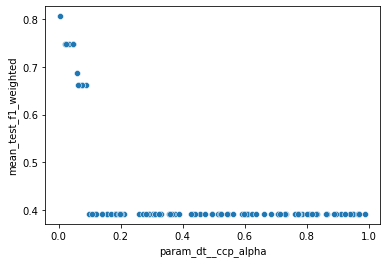

In [141]:
# tune DT ccp_alpha
dt_cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer(lowercase=False,stop_words= [None],ngram_range=(1,3))),
                     ('dt',DecisionTreeClassifier(random_state=42))
])
# parameters to search over 
dt_cvec_params = {
    'dt__ccp_alpha':uniform(0,1) # default is 1 
}
# instantiate randome search over 100 values between 0 and 1
dt_cvec_rs0= RandomizedSearchCV(dt_cvec_pipe,dt_cvec_params,scoring=metrics,n_jobs=-1,refit='f1_weighted',cv=3,verbose=1,random_state=42,
                               n_iter=100)
dt_cvec_rs0.fit(X_train,y_train)


graph_cv_results(dt_cvec_rs0,'dt__ccp_alpha')

In [119]:
model_eval(dt_cvec_rs)

{'Training Accur Score': 0.6972700930303493,
 'Test Accur Score': 0.7102012808783166,
 'Training F1': 0.6622067637931398,
 'Test F1': 0.6771654046883974}

The mean weighted F1 score increases for values from 0.02 to 0. 

To find the optimal value for ccp_alpha we should focus our search in that range. 

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'Training Accur Score': 0.8200396522800061, 'Test Accur Score': 0.8380603842634949, 'Training F1': 0.8177341299616978, 'Test F1': 0.8355985797251343}


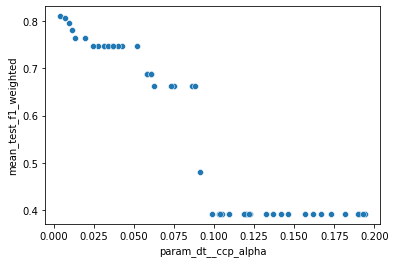

In [120]:
# tune DT ccp_alpha from 0 to 0.2 
dt_cvec_pipe= Pipeline([
                     ('cvec',CountVectorizer(lowercase=False,stop_words= [None],ngram_range=(1,3))),
                     ('dt',DecisionTreeClassifier(random_state=42))
])
# params to search over 
dt_cvec_params = {
    'dt__ccp_alpha':uniform(0,0.2) # search between 0 and 0.2 
}
# instantitate random search for 100 values between 0 and 0.2 
dt_cvec_rs= RandomizedSearchCV(dt_cvec_pipe,dt_cvec_params,scoring=metrics,n_jobs=-1,refit='f1_weighted',cv=3,verbose=1,random_state=42,
                               n_iter=50)
# perform search
dt_cvec_rs.fit(X_train,y_train)
#check results 
graph_cv_results(dt_cvec_rs,'dt__ccp_alpha')
print(model_eval(dt_cvec_rs))

In [121]:
# print best value for cost complexity pruning alpha from search 
dt_cvec_rs.best_params_

{'dt__ccp_alpha': 0.004116898859160489}

After applying the ccp_alpha value of 0.0041 the decision tree model is no longer overfit. 
  - The test and train accuracy scores are within 0.02 of each other 

The accuracy and F1 score are both lower with the less overfit version of the decision tree compared to the final naive bayes model.

This could possibly be improved by using other tree modeling methods such as bagging and random forest.  

The final decision tree model still performs about 30% better then the baseline model. 


# Conclusion and Recommendations

The significant improvement from the baseline model in both the naive bayes and decision tree model suggests that it is possible to label submissions as “fake news” or “real news” based on the title.


Recommend training model on more subreddits before deploying the feature across all of reddit. 

Recommend testing other classification models like random forest to see if better accuracy can be achieved. 

Limitations of current model: 
- Not much data cleaning was performed so it may be possible to get better features after cleaning the data further  
- Basic transformer to vectorize text use used. By using a more complex transformer, such as TFIDF, that retains more of the context in the text it may be possible to get better results.  
- The model was only trained on two subreddits so the models ability to generalize to other subreddits may be limited. 
-  Only text from title of post was used for this model so it is likely that by adding other important features and metadata the model will perform better 
